### **Loading Modules and Libraries**

In [135]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# data manipulation and text 
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

### **Loading the Data and getting insight**

In [136]:
# getting the paths of each email type
legitimate_emails = 'data/legiti_emails/'
spam_emails = 'data/spam_emails/'

----------

In [137]:
# defining a function to load the data
def get_data(path):
    # setting an empty list to store the data
    data = []
    files = os.listdir(path) # getting the files
    
    for file in files:
        # getting the file and loading it in memory
        processed_file = open(path + file, encoding = "ISO-8859-1")
        # reading the file
        words_list = processed_file.read()
        # appending the processed data
        data.append(words_list)
        # closing the file
        processed_file.close()
    
    # returning the final result
    return data

------

In [138]:
# getting the files for each email type

# legitimate emails
ham = get_data(legitimate_emails)

# the spam emails
spam = get_data(spam_emails)

---

In [139]:
# cleaning the emails
def clean_emails(emails):
    # a list of cleaned emails to store them
    cleaned_emails = []
    
    for email in emails:
        # Split the email into lines
        lines = email.split('\n')

        # Get the content of the email
        content = ''
        for line in lines:
            if line.startswith('Subject:'):
                subject = line.replace('Subject:', '').strip()
            elif line.startswith('From:'):
                sender = line.replace('From:', '').strip()
            elif line.startswith('To:'):
                recipient = line.replace('To:', '').strip()
            elif line.startswith('Date:'):
                date = line.replace('Date:', '').strip()
            elif line.startswith('X-'):
                continue
            else:
                content += line.strip()

        # Append the cleaned email to the list of cleaned emails
        cleaned_emails.append({'content': content})

    return cleaned_emails

----

In [140]:
# Clean the legitimate and spam emails
cleaned_ham = clean_emails(ham)
cleaned_spam = clean_emails(spam)

---

In [141]:
# getting the data as a dataframe
legitimate = pd.DataFrame(cleaned_ham)

# getting the data as a dataframe
spam = pd.DataFrame(cleaned_spam)

---

In [142]:
# taking a look at the data
spam.head()

,content
0,From lvi300702@free.fr Tue Aug 6 12:50:59 20...
1,Received: from hq.pro-ns.net (localhost [127.0...
2,From edum@hkem.com Mon Jun 24 17:04:26 2002Re...
3,From blissptht65@yahoo.com Thu Jul 12 06:33:5...
4,Received: from hq.pro-ns.net (localhost [127.0...


In [143]:
# taking a look at the legitimate emails
legitimate.head()

,content
0,Return-Path: <Online#3.19846.2a-726zgP3UI7kTO9...
1,From rssfeeds@jmason.org Mon Sep 30 13:43:46 ...
2,From fork-admin@xent.com Tue Sep 3 14:24:41 ...
3,From exmh-users-admin@redhat.com Wed Sep 11 1...
4,From fork-admin@xent.com Mon Sep 2 16:22:12 ...


### **Creating a Bag of Words**

In [144]:
def preprocess_text(text):
    # function to check if a word is a valid English word
    def is_english_word(word):
        synsets = wordnet.synsets(word)
        return len(synsets) > 0 and synsets[0].lemmas()[0].name() == word.lower()

    # remove non-word characters and numbers using regular expressions
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # tokenize the text
    tokens = word_tokenize(text.lower())

    # remove English stop words
    english_stopwords = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in english_stopwords]

    # filter out non-English words
    english_words = [token for token in filtered_tokens if is_english_word(token)]
    
    return english_words

In [145]:
# applying the function to the legit emails content
legitimate['content'] = legitimate['content'].apply(preprocess_text)

In [146]:
# taking a look at the data now
legitimate.head()

,content
0,"[investor, width, width, width, height, invest..."
1,"[fourth, art, home, gangster]"
2,"[unknown, mesh, new, give, fast, trouble, able..."
3,"[message, discussion, list, probably, local, m..."
4,"[sun, sun, developer, solve, memory, managemen..."


In [147]:
# doing the same for spam emails
spam['content'] = spam['content'].apply(preprocess_text)

In [148]:
# taking a look now
spam.head()

,content
0,"[inscription, en, en, en, contact, pour, pour,..."
1,"[submit, exchange, internet, mail, service, ve..."
2,"[development, list, one, union, independence, ..."
3,"[free, casino, potential, free, internet, gamb..."
4,"[submit, days, sending, impossible, catch, cat..."


In [149]:
# checking if legit emails are different from spam ---> Yes!
set(spam['content'][2]).intersection(set(legitimate['content'][2]))

{'able',
 'beginning',
 'company',
 'establish',
 'give',
 'hundred',
 'new',
 'say',
 'soon'}

### Checking the Ratio of Spam to Legit

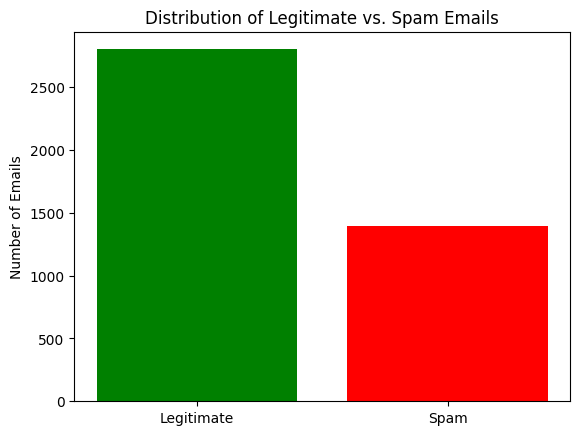

In [150]:
import matplotlib.pyplot as plt

legit_count = len(legitimate)
spam_count = len(spam)

fig, ax = plt.subplots()

ax.bar(["Legitimate", "Spam"], [legit_count, spam_count], color = ["green", "red"])

ax.set_ylabel("Number of Emails")
ax.set_title("Distribution of Legitimate vs. Spam Emails")

plt.show()

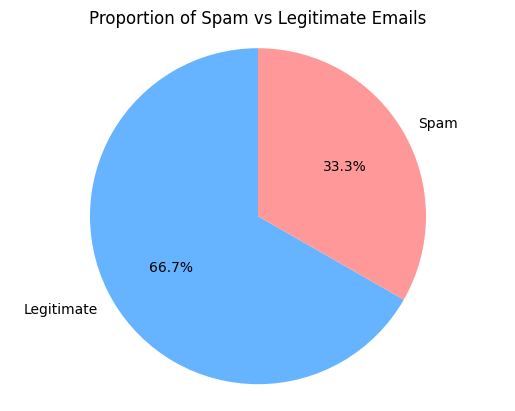

In [151]:
labels = ['Legitimate', 'Spam']
sizes = [len(legitimate), len(spam)]
colors = ['#66b3ff', '#ff9999']

plt.pie(sizes, labels = labels, colors = colors, autopct = '%1.1f%%', startangle = 90)

plt.axis('equal')
plt.title('Proportion of Spam vs Legitimate Emails')

plt.show()

### Generating Sets

In [152]:
# creating labels for spam and legit, where spam is 0 and legitimate is 1
target = np.array(len(legitimate['content']) * [1] + len(spam['content']) * [0])

In [153]:
# taking a look at our target
target[-1], target[0] # our target of 0s and 1s

(0, 1)

In [154]:
# creating the features
features = list(legitimate['content']) + list(spam['content'])

In [155]:
# taking a look at some features
features[0][0:3]

['investor', 'width', 'width']

In [156]:
# converting the features and target to numpy arrays and reshaping them
features, target = np.array(features, dtype = object).reshape(-1, 1), np.array(target).reshape(-1, 1)

---

In [157]:
# using stratified random split to generate training and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, stratify = target, test_size = 0.2, random_state = 0)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)

In [158]:
# looking at the shapes
print('X_train: {}, X_test: {}, y_train: {}, y_test: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape)) 

X_train: (2518, 1), X_test: (840, 1), y_train: (2518, 1), y_test: (840, 1)


In [159]:
# looking at the shapes
print('X_train: {}, X_test: {}, X_val: {}, y_val: {}'.format(X_train.shape, X_test.shape, X_val.shape, y_val.shape)) 

X_train: (2518, 1), X_test: (840, 1), X_val: (840, 1), y_val: (840, 1)


### Creating a Feature Vector

In [160]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_data(X_train, X_test, y_train, y_test, X_val, y_val):
    # Convert X_train to a list of strings and convert to lowercase
    X_train = [str(x).lower() for x in X_train]
    
    # Convert X_test to a list of strings and convert to lowercase
    X_test = [str(x).lower() for x in X_test]
    
    # Convert X_val to a list of strings and convert to lowercase
    X_val = [str(x).lower() for x in X_val]
    
    # Initialize CountVectorizer and fit training data
    count_vect = CountVectorizer(stop_words='english')
    count_vect.fit(X_train)

    # Vectorize the training data
    X_train = count_vect.transform(X_train).toarray()
    y_train = np.array(y_train).reshape(len(y_train), 1)

    # Vectorize the testing data
    X_test = count_vect.transform(X_test).toarray()
    y_test = np.array(y_test).reshape(len(y_test), 1)
    
    # Vectorize the validation data
    X_val = count_vect.transform(X_val).toarray()
    y_val = np.array(y_val).reshape(len(y_val), 1)

    return X_train, X_test, y_train, y_test, X_val, y_val

# vectorizing the training, validation, and test sets
X_train_vec, X_test_vec, y_train_vec, y_test_vec, X_val_vec, y_val_vec = vectorize_data(X_train, X_test, y_train, y_test, 
                                                                                        X_val, y_val)

In [161]:
# looking at the shapes
print('{}, {}, {}, {}'.format(X_train_vec.shape, X_test_vec.shape, y_train_vec.shape, y_test_vec.shape))

(2518, 6867), (840, 6867), (2518, 1), (840, 1)


In [162]:
# looking at the shapes
print('{}, {}, {}, {}'.format(X_train_vec.shape, X_test_vec.shape, X_val_vec.shape, y_val_vec.shape))

(2518, 6867), (840, 6867), (840, 6867), (840, 1)


### Building the Model

In [163]:
# using a neural network to predict the target
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

# define the model architecture
model = Sequential()
model.add(Dense(64, input_dim = X_train_vec.shape[1], activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

# compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# add early stopping to prevent overfitting
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, restore_best_weights = True)

# add model checkpoint to save best model during training
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only = True, monitor = 'val_accuracy', mode = 'max', verbose = 1)

# train the model
history = model.fit(X_train_vec, y_train_vec, epochs = 100, batch_size = 32, validation_data = (X_val_vec, y_val_vec), 
                    callbacks = [early_stop, model_checkpoint], verbose = 1)

# evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_vec, y_test_vec, verbose = 0)
print('Test accuracy: {:.2f}'.format(accuracy))

ModuleNotFoundError: No module named 'tensorflow'

### Plotting the Performance

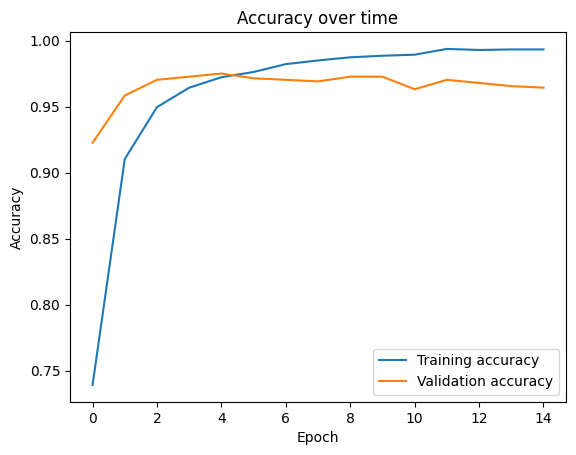

In [ ]:
# plot the change of accuracy over time
plt.plot(history.history['accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Accuracy over time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

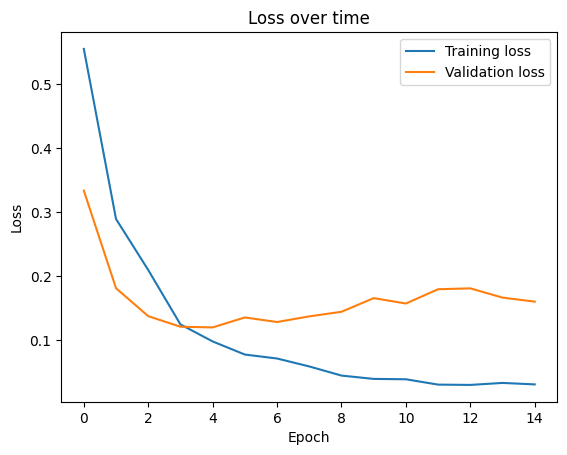

In [ ]:
# plot the change of loss over time
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()